# Linear Regression with PyMC3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from random import sample
import pymc3 as pm

import warnings
warnings.filterwarnings('ignore')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## What is Linear Regression?

linear regression is a **linear** approach to modelling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables). Several situations can happen:
- One dependent variable and one independent variable: **Simple linear regression**
- One dependent variable and more than one independent variable: **Multiple linear regression**
- More than one dependent variable (with normally distributed noise/error/variability): **Multivariate linear regression** (aka **general linear model**)
- More than one dependent variable (noise/error/variability is not normally distributed): **Generalized linear model**

The **general linear model** incorporates a number of different statistical models: ANOVA, ANCOVA, MANOVA, MANCOVA, ordinary linear regression, t-test and F-test.

The **generalized linear model (GLM)** is addressed in the Logistic Regression section.

## How to do linear regression in a probabilistic manner?

Let's take a simple example, simple linear regression, where we have X as the explanatory (independent) variable and Y as the response (dependent) variable. Most commonly these dependencies are modeled as follow:

## How to implmement this in PyMC3?

In [2]:
def gen_data_lr(n, x_range, intercept=None, slope=None, noise_std=None):
    # generate parameter values randomly
    beta_0 = intercept if intercept else 0
    beta_1 = slope if slope else 1
    std = noise_std if noise_std else np.round(np.random.uniform(.5, 2), 1)
    
    X_vals, (X, Y) = np.arange(*x_range), np.zeros((2, n))
    for ind in range(n):
        X[ind] = sample(list(X_vals), 1)[0]
        y_mean = beta_0+beta_1*X[ind]
        Y[ind] = np.random.normal(loc=y_mean, scale=std) if noise_std else y_mean
        
    return X, Y, beta_0, beta_1, std

In [3]:
X, Y, beta_0, beta_1, std = gen_data_lr(n=10000, x_range=(0, 5, .1), intercept=1, noise_std=.7)

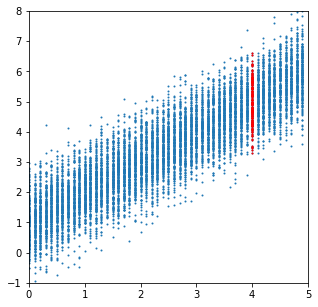

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X, Y, s=1)

mask_value = 4.
Y_line = Y[X==mask_value]
ax.scatter(np.zeros(Y_line.shape) + mask_value, Y_line, s=1, c='r');
ax.set(xlim=(0, 5), ylim=(-1, 8));

In [5]:
with pm.Model() as basic_model:

    # Priors for unknown model parameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Linear predictor
    eeta = beta_0 + beta_1 * X
    
    # Linking function (for mean only)
    mu = eeta

    # Data distribution
    Y_dist = pm.Normal('Y_dist', mu=mu, sd=sigma, observed=Y)

In [6]:
with basic_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_1]
>Metropolis: [beta_0]
The estimated number of effective samples is smaller than 200 for some parameters.


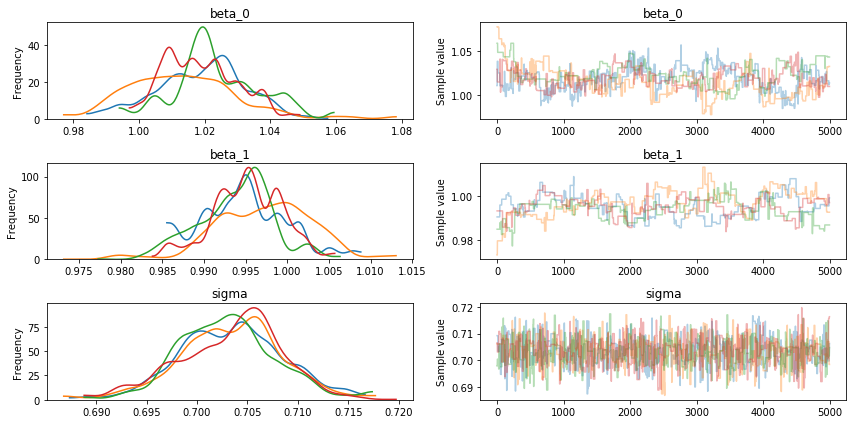

In [7]:
pm.traceplot(trace);

In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,1.018724,0.013994,0.001151,0.991900,1.044830,38.698093,1.048594
beta_1,0.995326,0.005021,0.000424,0.985597,1.005172,39.640041,1.042390
sigma,0.703307,0.004989,0.000143,0.692212,0.711948,1085.193855,1.000725


Now, using these parameters we can generate some new data, over the same range of X values, and compare it with our actual data

In [9]:
Y_mu = trace['beta_0'].mean() + trace['beta_1'].mean() * X
Y_gen = np.random.normal(Y_mu, trace['sigma'].mean())

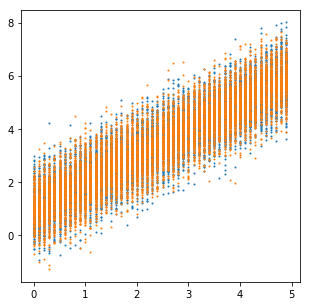

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X, Y, s=1)
ax.scatter(X, Y_gen, s=1);

### Dependent variance?

In [12]:
with pm.Model() as basic_model:

    # Priors for unknown model parameters
    beta_0 = pm.Normal('beta_0', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    theta_0 = pm.HalfNormal('theta_0', sd=1)
    theta_1 = pm.HalfNormal('theta_1', sd=1)
    
    # Linear predictor
    eeta = beta_0 + beta_1 * X
    sigma = theta_0 + theta_1 * X
    
    # Linking function (for mean only)
    mu = eeta
    sd = sigma

    # Data distribution
    Y_dist = pm.Normal('Y_dist', mu=mu, sd=sd, observed=Y)

In [13]:
with basic_model:

    # instantiate sampler
    step = pm.Metropolis()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta_1]
>Metropolis: [theta_0]
>Metropolis: [beta_1]
>Metropolis: [beta_0]
The estimated number of effective samples is smaller than 200 for some parameters.


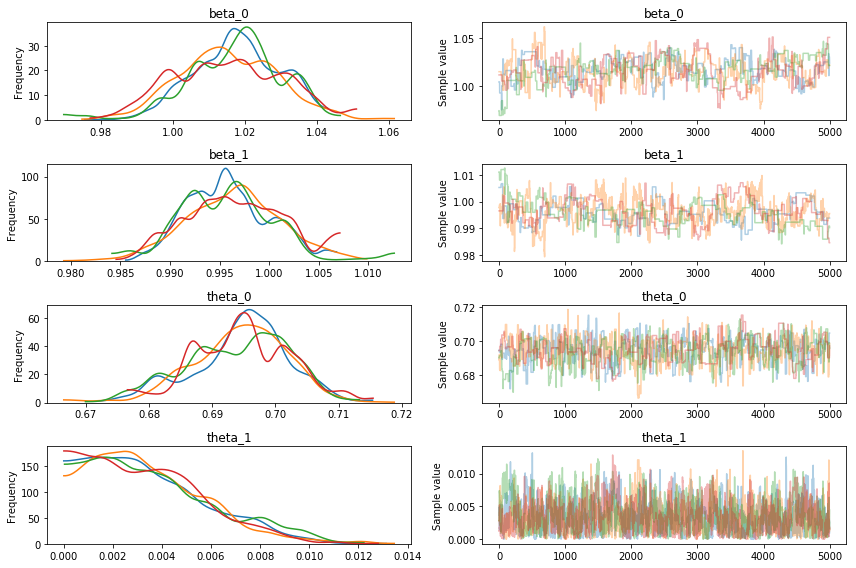

In [14]:
pm.traceplot(trace);

In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_0,1.016523,0.013442,0.000996,0.991524,1.040148,125.548639,1.004285
beta_1,0.996153,0.004666,0.000344,0.987551,1.005648,118.275285,1.002937
theta_0,0.694469,0.007591,0.000376,0.679138,0.707911,360.023189,1.001812
theta_1,0.003476,0.002394,0.000107,0.000010,0.008094,448.361903,1.001589


**Note** that the mean of the theta_0 here is very close the sigma in the previous case.

In [16]:
Y_mu = trace['beta_0'].mean() + trace['beta_1'].mean() * X
Y_sd = trace['theta_0'].mean() + trace['theta_1'].mean() * X
Y_gen = np.random.normal(Y_mu, Y_sd)

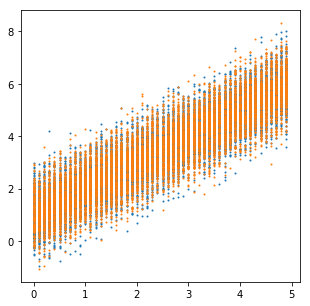

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X, Y, s=1);
ax.scatter(X, Y_gen, s=1);